In [2]:
import os
import ast
import csv
import glob
import json
import ineqpy
import numpy as np
import pandas as pd
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go

from scipy import stats
from pathlib import Path
from collections import Counter
from collections import defaultdict

In [33]:
path_data = Path("../data")
path_meta = Path("../meta")
path_rq1 = path_meta / 'rq1'
path_rq2 = path_meta / 'rq2'

platform_abbreviation_mapping = {
    'ai2': 'Allen Institute for AI',
    'gh': 'GitHub',
    'hf': 'HuggingFace',
    'pwc': 'PapersWithCode',
    'ihw': 'Independently-hosted website',
}

platform_template = [
    'ai2',
    'pwc'
]

platform_nontemplate = [
    'gh',
    'hf',
    'ihw'
]

platform_template_fullname = [platform_abbreviation_mapping[platform] for platform in platform_template]
platform_nontemplate_fullname = [platform_abbreviation_mapping[platform] for platform in platform_nontemplate]

leaderboard_organization_strategies_mapping = {
    'Evaluation Configuration': ['Evaluation Dataset', 'Evaluation Metrics', 'Evaluator'],
    'Leaderboard Layout': ['Aggregated Result'],
    'Leaderboard Release': ['Leaderboard Version', 'Leaderboard Launch Date'],
    'Model Capability': ['Benchmark', 'Supported Functionality', 'Supported Language', 'Supported Modality', 'Task'],
    'Model Information': ['Model Accessibility', 'Model Size', 'Model Type'],
    'Prompt Configuration': ['#Multiple Choice Options', '#Prompt Example', 'Prompt Length', 'Prompt Pipeline', 'Tokenizer']
}

submission_synonyms = {
    'Instant Message': ['WeChat']
}

organizer_synonyms = {
    'Alibaba Group': ['Alibaba Group DAMO Academy'],
    'Amazon': ['Amazon Alexa AI Lab', 'Amazon AWS AI Lab'],
    'Google': ['Google DeepMind'],
    'Huawei': ["Huawei Noah's Ark Lab"],
    'Meta': [
        'Meta FAIR',
        'Meta GenAI'
    ],
    'Microsoft': ['Microsoft Research Asia'],
    'Tencent': [
        'Tencent AI Lab',
        'Tencent ARC Lab',
        'Tencent Youtu Lab'
    ],
    'University of California': [
        'University of California Berkeley',
        'University of California Los Angeles',
        'University of California Santa Barbara',
        'University of California San Diego',
    ],
    'University of North Carolina': ['University of North Carolina Chapel Hill'],
    'University of Illinois': ['University of Illinois Chicago', 'University of Illinois Urbana Champaign'],
    'University of Massachusetts': ['University of Massachusetts Amherst'],
    'University of Maryland': ['University of Maryland College Park'],
    'University of Tennessee': ['University of Tennessee Knoxville'],
    'University of Wisconsin': ['University of Wisconsin Madison']
}

metrics_synonyms = {
    'accuracy': [
        'acc',
        'accuarcy',
        'qa accuracy'
    ],
    'average': [
        'avg',
        '平均'
    ],
    'average accuracy': [
        'avg. accuracy'
    ],
    'average score': ['平均分'],
    'bleu': ['bleu score'],
    'bleu-1': [
        'narrativeqa bleu-1',
        'socialiqa bleu-1',
        'mcscript bleu-1',
        'cosmosqa bleu-1'
    ],
    'bleu-4': ['bleu4'],
    'bertscore': ['bert score'],
    'code': ['代码'],
    'elo rating': [
        'chatbot arena elo',
        'elo'
    ],
    'exact match': ['em', 'exact match accuracy'],
    'lerc': [
        'cosmosqa lerc',
        'mcscript lerc',
        'socialiqa lerc',
        'narrativeqa lerc'
    ],
    'link': ['url'],
    'mean rank': [
        'text-to-video mean rank',
        'video-to-text mean rank'
    ],
    'median rank': [
        'text-to-video median rank',
        'video-to-text median rank',
        'text-to-videomedian rank',
        'text-to-video medianr'
    ],
    'meteor': [
        'cosmosqa meteor',
        'narrativeqa meteor',
        'socialiqa meteor',
        'mcscript meteor'
    ],
    'neg mean rank': [
        'i->t neg mean rank',
        't->i neg mean rank'
    ],
    'organization': [
        '发布机构',
        '机构',
        'orgaisation',
    ],
    'others': ['其他'],
    'overall': ['xiezhi overall'],
    'overall score': [
        '总分',
        '总体分数'
    ],
    'pass@1': [
        'interview pass@1',
        'competition pass@1',
        'introductory pass@1'
    ],
    'pass@5': [
        'interview pass@5',
        'introductory pass@5',
        'competition pass@5'
    ],
    'pass@1000': [
        'interview pass@1000',
        'competition pass@1000',
        'introductory pass@1000'
    ],
    'pass@any': [
        'introductory pass@any',
        'competition pass@any',
        'interview pass@any'
    ],
    '#parameters':  [
        '#params',
        '# params',
        '#size',
        '参数量',
        'model size',
        'model size/b',
        'number of params',
        'param',
        'parameters',
        'params',
        'size'
    ],
    'perplexity': ['ppl'],
    'precision@1': ['i->t p@1'],
    'precision@20': ['p@20'],
    'recall@1': [
        'r@1',
        'text-to-videor@1',
        'video-to-text r@1',
        'text-to-video r@1',
        'text-to-image r@1',
        'image-to-text r@1'
    ],
    'recall@5': [
        'text-to-image r@5',
        'video-to-text r@5',
        'image-to-text r@5',
        'text-to-video r@5',
        'r@5',
    ],
    'recall@10': [
        'recall@10 on 1 rounds',
        'recall@10 on 2 rounds',
        'recall@10 on 3 rounds',
        'r@10',
        'video-to-text r@10',
        'text-to-image r@10',
        'text-to-video r@10',
        'image-to-text r@10'
    ],
    'recall@50': [
        'text-to-video r@50',
        'video-to-text r@50',
    ],
    'score': ['分数'],
    'submission date': ['提交时间'],
    'top-1 accuracy': ['top 1 accuracy'],
    'top-5 accuracy': ['top 5 accuracy'],
    'type': ['model type'],
    'win rate': ['胜率'],
    'word error rate': ['wer']
}

model_naming_convention = {
    'Model Publisher (first line)': [
        'Provider Leaderboard'
    ],
    'Repository Username': [
        'EQ-Bench (v2)',
        'HHEM Leaderboard',
        'Big Code Models Leaderboard',
        'Colossal-AI',
        'DecodingTrust',
        'LLMPerf Leaderboard',
        'LLM-Perf Leaderboard',
        'Open LLM Leaderboard',
        'Open Ko-LLM Leaderboard',
        'ScandEval'
    ],
}

dashed_model_leaderboards = ['MMCU', 'SuperCLUE-Math6']

metrics_synonyms_inverse = {}
for key, values in metrics_synonyms.items():
    for value in values:
        metrics_synonyms_inverse[value] = key
        
submission_synonyms_inverse = {}
for key, values in submission_synonyms.items():
    for value in values:
        submission_synonyms_inverse[value] = key

organizer_synonyms_inverse = {}
for key, values in organizer_synonyms.items():
    for value in values:
        organizer_synonyms_inverse[value] = key

leaderboard_organization_strategies_mapping_inverse = {}
for key, values in leaderboard_organization_strategies_mapping.items():
    for value in values:
        leaderboard_organization_strategies_mapping_inverse[value] = key

model_naming_convention_count = {
    k: len(v) for k, v in model_naming_convention.items()}

def convert_csv_to_dict(file_path):
    """
    Convert a CSV file of leaderboards and metrics to a dictionary.

    :param file_path: Path to the CSV file
    :return: Dictionary with leaderboards as keys and list of metrics as values
    """
    leaderboard_data = {}

    # Read the CSV file
    with open(file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header row

        # Iterate through each row
        for row in csv_reader:
            if row:  # Check if row is not empty
                key = row[0]  # The first element is the key
                # List comprehension to get non-empty values
                values = [value for value in row[1:] if value]
                leaderboard_data[key] = values

    return leaderboard_data


def transform_platform(groups):
    groups_processed = []
    for group in groups:
        group_processed = []
        for platform in group.split('_'):
            group_processed.append(platform_abbreviation_mapping[platform])
        groups_processed.append(group_processed)
    return groups_processed


def faltten_flatten_platform(groups):
    groups_processed = []
    for group in groups:
        group_processed = []
        for platform in group.split('_'):
            group_processed.append(platform_abbreviation_mapping[platform])
        groups_processed.extend(group_processed)
    return groups_processed


def filter_platform(groups, filters):
    groups_processed = []
    for group in groups:
        group_processed = []
        for platform in group:
            if platform not in filters:
                group_processed.append(platform)
        if group_processed:
            groups_processed.append(group_processed)
    return groups_processed


def split_string(text):
    if pd.isna(text):
        return []
    return text.split(',')


# Function to format each value based on its own decimal places
def format_individual_value(x):
    if isinstance(x, float):
        # Use string formatting to maintain original decimal places
        return "{:f}".format(x).rstrip('0').rstrip('.')
    return x


def print_empty_folders(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Check if both lists of subdirectories and filenames are empty
        if not filenames:
            print(f"Empty folder: {dirpath}")


def file_rename(name, channel):
    name = name.lower()
    name = name.replace(' - ', '-')
    name = name.replace(' ', '_')
    name = name.replace(".csv", ".json")
    if channel:
        name = f'{channel}-{name}'
    return name


def process_model(model_str):
    if ('*' in model_str) and ('*' == model_str[-1]):
        model_str = model_str[:-1]
        
    if '](' in model_str:
        model_str = model_str.split('](')[0][1:]
        
    # Substrings to be removed
    substrings_to_remove = ['🥇', '🥈', '🥉', '🗒️', '📄', '🌍']
    
    # Remove each unwanted substring
    for substring in substrings_to_remove:
        model_str = model_str.replace(substring, '')
        
    return model_str.strip()
    

def list_directories(folder_path):
    # List all subdirectories within the folder
    directories = [os.path.join(folder_path, d) for d in os.listdir(
        folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    return directories


def organizer_synonyms_mapping(organizers, leaderboard):
    organizers_processed = set()
    for organizer in organizers:
        if organizer in organizer_synonyms_inverse:
            organizers_processed.add(organizer_synonyms_inverse[organizer])
        elif 'Independent Contributor' == organizer:
            organizers_processed.add(leaderboard)
        else:
            organizers_processed.add(organizer)
    return list(organizers_processed)


def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

In [4]:
df = pd.read_csv(path_rq1 / 'Leaderboard.csv')

for index, row in df.iterrows():
    folder_path = os.path.join(path_data, row['Leaderboard name'])
    os.makedirs(folder_path, exist_ok=True)

print_empty_folders(str(path_data))

In [6]:
directory = path_data / "VisualWebArena"
channel = ''

for file in glob.glob(str(directory / "*.csv")):
    df = pd.read_csv(file)
    filename = file.split('/')[-1]
    filename = file_rename(filename, channel)
    df.to_json(directory / filename, orient="records", indent=4)
    os.remove(file)


In [16]:
# Aligning Diverse Leaderboards for Standardized Analysis 
for directory in os.listdir(path_data):
    dash = directory in dashed_model_leaderboards
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        try:
            df = pd.read_json(file)
            if 'Model' not in df.columns:
                if file.startswith('ai2'):
                    df.rename(columns={'Submission': 'Model'}, inplace=True)
            df = df.dropna(subset=['Model'])
            df['Model'] = df['Model'].str.replace('_', '-') if dash else df['Model'].apply(process_model)
            df.to_json(file, orient='records', indent=4)
        except:
            print(file)


In [25]:
total_records = 0
total_publishers = 0
total_splits = 0
total_benchmarks = 0
# total_template_scenarios = 0
# total_template_publishers = 0
# total_nontemplate_scenarios = 0
# total_nontemplate_publishers = 0

for folder in list_directories(path_data):
    total_benchmarks += 1
    prefixes = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                df = pd.read_json(file_path)
                total_records += len(df)
                total_splits += 1
                for prefix in platform_abbreviation_mapping.keys():
                    if file.startswith(prefix):
                        prefixes.append(prefix)
                        break
                    
    total_publishers += len(set(prefixes))
    template_publishers = [p for p in prefixes if p not in platform_nontemplate]
    nontemplate_publishers = [p for p in prefixes if p in platform_nontemplate]
    # total_template_publishers += len(set(template_publishers))
    # total_nontemplate_publishers += len(set(nontemplate_publishers))
    # total_template_scenarios += len(template_publishers)
    # total_nontemplate_scenarios += len(nontemplate_publishers)

print(f"Total number of evaluation records: {total_records}")
print(f"Total number of leaderboards (benchmark): {total_benchmarks}")
print(f"Total number of leaderboards (publisher): {total_publishers}")
print(f"Total number of leaderboards (split): {total_splits}")
# print(f"Total number of leaderboards (publisher) (template): {total_template_publishers}")
# print(f"Total number of leaderboards (scenario) (template): {total_template_scenarios}")
# print(f"Total number of leaderboards (publisher) (non-template): {total_nontemplate_publishers}")
# print(f"Total number of leaderboards (scenario) (non-template): {total_nontemplate_scenarios}")


Total number of evaluation records: 52472
Total number of leaderboards (benchmark): 266
Total number of leaderboards (publisher): 293
Total number of leaderboards (scenario): 2240
Total number of leaderboards (publisher) (template): 153
Total number of leaderboards (scenario) (template): 542
Total number of leaderboards (publisher) (non-template): 140
Total number of leaderboards (scenario) (non-template): 1698


In [45]:
benchmark_mapping = convert_csv_to_dict(path_rq1 / 'Benchmark.csv')

leaderboard_benchmarks = set()
for key in benchmark_mapping.keys():
    benchmarks = [benchmark if benchmark == 'ARC (The Abstraction and Reasoning Corpus)' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]]
    leaderboard_benchmarks = leaderboard_benchmarks.union(set(benchmarks))
print('Benchmarks:', len(leaderboard_benchmarks))

leaderboard_tasks = set()
for key in benchmark_mapping.keys():
    tasks = set([benchmark for benchmark in benchmark_mapping[key]])
    leaderboard_tasks = leaderboard_tasks.union(tasks)
    benchmark_mapping[key] = list(tasks)
print('Tasks:', len(leaderboard_tasks))

df_benchmark = pd.DataFrame(list(benchmark_mapping.items()), columns=['Leaderboard name', 'Benchmarks'])
df_benchmark.to_csv(path_rq1 / 'Benchmark_processed.csv', index=False)

Benchmarks: 697
Tasks: 833


In [63]:
df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard.csv')
df_leaderboard['Feedback manners (ihw)'] = df_leaderboard['Feedback manners (ihw)'].apply(split_string)
df_leaderboard['Supported languages'] = df_leaderboard['Supported languages'].apply(split_string)
df_leaderboard['Leaderboard organization strategies (non-template)'] = df_leaderboard['Leaderboard organization strategies (non-template)'].apply(split_string)
df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(split_string)
df_leaderboard['Host platforms'] = df_leaderboard['Host platforms'].apply(split_string)
df_leaderboard['Host platforms'] = df_leaderboard['Host platforms'].apply(transform_platform)
df_leaderboard['Host platforms with model linkage (non-template)'] = df_leaderboard['Host platforms with model linkage (non-template)'].apply(split_string)
df_leaderboard['Publication venues'] = df_leaderboard['Publication venues'].apply(split_string)
df_leaderboard['Publishers (non-template)'] = df_leaderboard['Publishers (non-template)'].apply(split_string)
df_leaderboard['Submission artifacts (non-template)'] = df_leaderboard['Submission artifacts (non-template)'].apply(split_string)
df_leaderboard['Submission channels (non-template)'] = df_leaderboard['Submission channels (non-template)'].apply(split_string)

for index, row in df_leaderboard.iterrows():
    organizers = organizer_synonyms_mapping(row['Publishers (non-template)'], row['Leaderboard name'])
    if 'PapersWithCode' in row['Host platforms']:
        organizers.append('PapersWithCode')
    if 'Allen Institute for AI' in row['Host platforms']:
        organizers.append('Allen Institute for AI')
    df_leaderboard.at[index, '#Publishing Organization'] = len(organizers)

leaderboard_mapping = {leaderboard: [leaderboard] for leaderboard in df_leaderboard['Leaderboard name'].tolist()}
df_benchmark = pd.read_csv(path_rq1 / 'Benchmark_processed.csv')
df_benchmark['Benchmarks'] = df_benchmark['Benchmarks'].apply(ast.literal_eval)
benchmark_mapping = dict(zip(df_benchmark['Leaderboard name'], df_benchmark['Benchmarks']))
for key in benchmark_mapping.keys():
    benchmarks = set([benchmark if benchmark == 'ARC (The Abstraction and Reasoning Corpus)' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]])
    benchmark_mapping[key] = list(benchmarks)
for leaderboard in leaderboard_mapping.keys():
    if leaderboard in benchmark_mapping:
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard]
    elif leaderboard == 'MTEB':
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard] + benchmark_mapping['CMTEB']
benchmark_mapping_count = {key: len(value) for key, value in leaderboard_mapping.items()}
df_leaderboard['#Benchmark'] = df_leaderboard['Leaderboard name'].map(benchmark_mapping_count)

leaderboard_split_count = {}
leaderboard_submission_count = {}
leaderboard_model_count = defaultdict(int)
leaderboard_attributes = {}
# leaderboard_metrics_raw = {}
leaderboard_metrics = {}
pwc_default_columns = {'extra training data', 'paper', 'code', 'result', 'year', 'tags'}
ai2_default_columns = {'created'}
for directory in os.listdir(path_data):
    subdirectory_path = os.path.join(path_data, directory)
    split = 0
    submission = 0
    model_names = []
    template = set()
    template_raw = set()
    nontemplate = set()
    
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        df = pd.read_json(file)
        submission += len(df)
        if directory in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
        df['Model'] = df['Model'].apply(lambda x: x.split('\n')[0].split('(')[0].strip())
        model_names.extend(df['Model'].tolist())
        
        file_name = file.split('/')[-1]
        if file_name.startswith('pwc'):
            keys = set()
            for item in df['metrics']:
                for key in item.keys():
                    key_processed = key.split('(')[0].lower().strip()
                    if key_processed in metrics_synonyms_inverse:
                        keys.add(metrics_synonyms_inverse[key_processed])
                    else:
                        keys.add(key_processed)
            template = template.union(keys)
            template_raw = template_raw.union(keys).union(pwc_default_columns)
        elif file_name.startswith('ai2'):
            split += 1
            column_names = set()
            for column_name in df.columns.tolist():
                if column_name in ['Model', 'Created']:
                    continue
                column_name = column_name.lower()
                if column_name in metrics_synonyms_inverse:
                    column_names.add(metrics_synonyms_inverse[column_name])
                elif column_name:
                    column_names.add(column_name)
            template = template.union(column_names)
            template_raw = template_raw.union(column_names).union(ai2_default_columns)
        else:
            split += 1
            column_names = set()
            for column_name in df.columns.tolist():
                if column_name == 'Model':
                    continue
                column_name = column_name.split('\n')[0].split('(')[0].split(' - ')[-1].split(']')[-1].lower().strip().rstrip('.')
                if column_name in metrics_synonyms_inverse:
                    column_names.add(metrics_synonyms_inverse[column_name])
                elif column_name:
                    column_names.add(column_name)
            nontemplate = nontemplate.union(column_names)
            
    leaderboard_split_count[directory] = split
    leaderboard_submission_count[directory] = submission
    leaderboard_model_count[directory] = len(set(model_names))
    
    if len(template):
        leaderboard_metrics[directory] = template
        # leaderboard_metrics_raw[directory] = template_raw
    elif len(nontemplate):
        leaderboard_attributes[directory] = nontemplate
        
df_leaderboard['#Split'] = df_leaderboard['Leaderboard name'].map(leaderboard_split_count)
df_leaderboard['#Evaluated Model'] = df_leaderboard['Leaderboard name'].map(leaderboard_model_count)
df_leaderboard['#Evaluation Result'] = df_leaderboard['Leaderboard name'].map(leaderboard_submission_count)
df_leaderboard['#Attribute'] = df_leaderboard['Leaderboard name'].apply(lambda x: len(leaderboard_attributes[x]) if x in leaderboard_attributes else len(leaderboard_metrics[x]))

df_leaderboard['#Supported Language'] = df_leaderboard['Supported languages'].apply(lambda x: len(x))
df_leaderboard['#Supported Modality'] = df_leaderboard['Supported modalities'].apply(lambda x: len(x))
df_leaderboard['#Host Platform'] = df_leaderboard['Host platforms'].apply(lambda x: len(flatten_list_of_lists(x)))
df_leaderboard['#Organization Strategy'] = df_leaderboard['Leaderboard organization strategies (non-template)'].apply(lambda x: len(x))
# df_leaderboard['#Empty leaderboards'] = df_leaderboard['#Empty leaderboards (non-template)'].replace('?', np.nan)

df_leaderboard['Weight'] = 1
df_leaderboard.to_csv(path_rq1 / 'Leaderboard_processed.csv', index=False)


In [47]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df = df[df['Leaderboard organization strategies (non-template)'].map(len) > 0]
print(f"{len(df[df['#Empty leaderboards (non-template)'].notna()])} multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for {round(len(df[df['#Empty leaderboards (non-template)'].notna()])/len(df)*100,2)}% of the total.")
df['#Empty leaderboards (non-template)'].value_counts().reset_index()

5 multi-scenario leaderboards (excluding PapersWithCode) have missing scenarios, accounting for 1.85% of the total.


,#Empty leaderboards (non-template),count
0,2,3
1,18,1
2,?,1


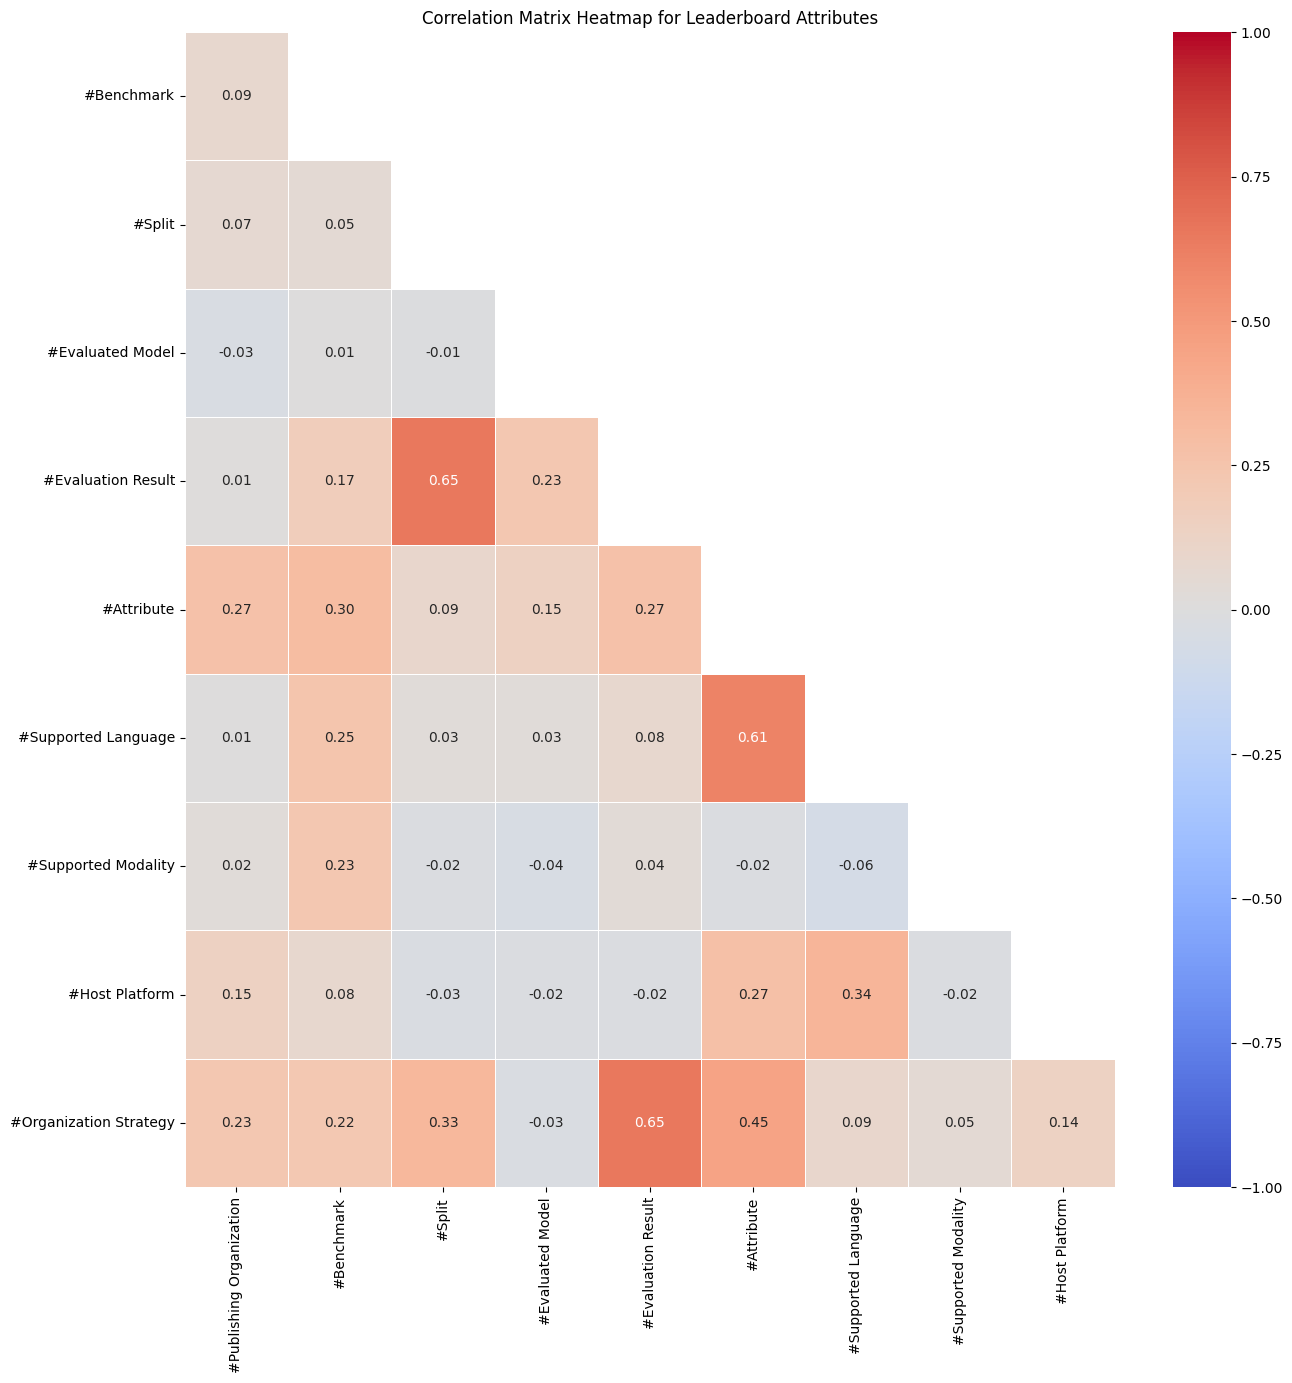

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Weight'])
corr_matrix = numeric_df.corr()

# Drop the first row
corr_matrix_dropped_row = corr_matrix.drop(corr_matrix.index[0])

# Drop the last column
corr_matrix_dropped = corr_matrix_dropped_row.drop(corr_matrix_dropped_row.columns[-1], axis=1)

# Generate a mask for the upper triangle, including the diagonal
mask = np.triu(np.ones_like(corr_matrix_dropped, dtype=bool), 1)

# Generate a heatmap for the correlation matrix with the mask
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix_dropped, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask, vmin=-1, vmax=1)

plt.title('Correlation Matrix Heatmap for Leaderboard Attributes')
plt.savefig(path_rq1 / 'leaderboard attribute heatmap.pdf', format='pdf')
plt.show()


In [61]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df_platform = df.explode('Host platforms')
print(f"Only {len(df_platform[df_platform['Host platforms'].map(len) > 1])} publishers host their leaderboards on multiple platforms, accounting for {round(len(df_platform[df_platform['Host platforms'].map(len) > 1])/len(df)*100,2)}% of the total.")

platform_counts = df_platform.explode('Host platforms')['Host platforms'].value_counts().reset_index()
print(f"{platform_counts['Host platforms'].iloc[0]} is the most popular host platform, accounting for {round(platform_counts['count'].iloc[0]/len(df)*100,2)}% benchmark-based leaderboards.")
platform_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=platform_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=platform_counts['Host platforms'],
    y=platform_counts['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Number of Leaderboards'},
    title='Frequency of Leaderboard across Different Platform'
)
fig.write_image(path_rq1 / 'host platform distribution.pdf')
fig.show()

Only 33 publishers host their leaderboards on multiple platforms, accounting for 12.41% of the total.
PapersWithCode is the most popular host platform, accounting for 51.5% benchmark-based leaderboards.
Gini Coefficient: 0.46472392638036814


In [53]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

mean = np.mean(df['#Publishing Organization'])
median = np.median(df['#Publishing Organization'])
mode = stats.mode(df['#Publishing Organization'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Publishing Organization'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Publishing Organization', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Publishing Organization', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} is the leaderboard involving the most number of publishing organization up to {df_top['#Publishing Organization'].iloc[0]}.")

fig = go.Figure(go.Bar(
        x=df_top['#Publishing Organization'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Publishing Organization'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Publishing Organization across Leaderboards (Top 10)',
        xaxis_title='Publishing Organization Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
# fig.write_image(path_rq1 / 'publishing organization distribution (top-10).pdf')
fig.show()


Mean: 1.6051660516605166
Median: 1.0
Mode: 0.0
Variance: 8.246320175378878
Standard Deviation: 2.8716406765782656
Gini Coefficient: 0.6844444444444385
TrustLLM is the leaderboard involving the most number of publishing organization up to 36.0.


In [55]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Publishers (non-template)'] = df['Publishers (non-template)'].apply(ast.literal_eval)

for index, row in df.iterrows():
    organizers = organizer_synonyms_mapping(row['Publishers (non-template)'], row['Leaderboard name'])
    if 'PapersWithCode' in row['Host platforms']:
        organizers.append('PapersWithCode')
    if 'Allen Institute for AI' in row['Host platforms']:
        organizers.append('Allen Institute for AI')
    df.at[index, 'Publishers (non-template)'] = organizers
    
organizer_mapping = df.set_index('Leaderboard name')['Publishers (non-template)'].to_dict()
org_item_count = Counter(org for orgs in organizer_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Publishers (non-template)', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Publishers (non-template)'].iloc[0]} is the most productive publisher among the {len(df)} publishers, accounting for {round(df_top['#Leaderboard'].iloc[0]/df['#Leaderboard'].sum()*100,2)}% ({df_top['#Leaderboard'].iloc[0]} out of {df['#Leaderboard'].sum()}) leaderboards.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Publishers (non-template)'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards across Publishers (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Publisher Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'publisher distribution (top-10).pdf')
fig.show()


Mean: 3.1837837837837837
Median: 1.0
Mode: 1
Standard Deviation: 10.380790823218272
Gini Coefficient: 0.6027902856720999
PapersWithCode is the most productive publisher among the 185 publishers, accounting for 23.26% (137 out of 589) leaderboards.


In [86]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=platform_template_fullname)
df = df[df['Host platforms'].map(len) > 0]

df['Host platforms with model linkage (non-template)'] = df['Host platforms with model linkage (non-template)'].apply(ast.literal_eval)
print(f"{len(df[df['Host platforms with model linkage (non-template)'].map(len) > 0])} non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for {round(len(df[df['Host platforms with model linkage (non-template)'].map(len) > 0])/len(df),4)*100}% of the total.")
df_provenance = df[df['Host platforms with model linkage (non-template)'].map(len) > 0]
df_provenance = df_provenance.explode('Host platforms with model linkage (non-template)')
df_provenance['Host platforms with model linkage (non-template)'] = df_provenance['Host platforms with model linkage (non-template)'].map(platform_abbreviation_mapping)
df_provenance = df_provenance['Host platforms with model linkage (non-template)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Host platforms with model linkage (non-template)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Frequency of Leaderboards with Model Provenance Linkage across Different Platforms (non-template)'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

total_data = 0
# total_paper = 0
# total_code = 0
total_provenance = 0

# average_paper_rate = []
# average_code_rate = []
average_provenance_rate = []

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.startswith('pwc') and file.endswith(".json"):
            with open(os.path.join(root, file), 'r') as file:
                json_data = json.load(file)
                total_data += len(json_data)
                json_external = [external for external in json_data if type(external['external_source_url']) == str]
                total_provenance += len(json_external)
                if not len(json_external):
                    json_internal = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    total_provenance += len(json_internal)
                    average_provenance_rate.append(len(json_internal)/len(json_data))
                    # json_paper = [paper for paper in json_data if type(paper['paper']['id']) == int]
                    # total_paper += len(json_paper)
                    # average_paper_rate.append(len(json_paper)/len(json_data)*100)
                    # json_code = [code for code in json_paper if code['paper']['code'] == True]
                    # if len(json_code):
                    #     total_code += len(json_code)
                    #     average_code_rate.append(len(json_code)/len(json_paper)*100)

print(f'Total provenance rate across all leaderboard: {round(total_provenance/total_data, 4)*100}%, namely {total_provenance} out of {total_data} evaluation records.')
print(f'Average provenance rate across crowdsourced leaderboard: {round(sum(average_provenance_rate)/len(average_provenance_rate), 4)*100}%')


55 non-template leaderboards have accessible linkage to the evaluated models in their leaderboards, accounting for 39.86% of the total.


Total provenance rate across all leaderboard: 97.97%, namely 6628 out of 6765 evaluation records.
Average provenance rate across crowdsourced leaderboard: 98.95%


In [56]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=platform_template_fullname)
df = df[df['Host platforms'].map(len) > 0]
        
df['Submission channels (non-template)'] = df['Submission channels (non-template)'].apply(ast.literal_eval)
df['Submission artifacts (non-template)'] = df['Submission artifacts (non-template)'].apply(ast.literal_eval)
print(f"Of the {len(df)} non-template leaderboards collected, {len(df[df['Submission channels (non-template)'].map(len) > 0])} (accounting for {round(len(df[df['Submission channels (non-template)'].map(len) > 0])/len(df)*100,2)}%) do not explicitly encourage the submission of evaluation records.")

df = df[df['Submission channels (non-template)'].map(len) > 0]
df_manner = df.explode('Submission channels (non-template)')
df_manner['Submission channels (non-template)'] = df_manner['Submission channels (non-template)'].apply(lambda x: submission_synonyms_inverse[x] if x in submission_synonyms_inverse else x)
df_manner = df_manner['Submission channels (non-template)'].value_counts().reset_index()
print(f"{df_manner['Submission channels (non-template)'].iloc[0]} is the most popular Submission manner for non-template leaderboards, accounting for {round(df_manner['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_manner['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_manner, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_manner['Submission channels (non-template)'], 
    y=df_manner['count'],
    text_auto=True,
    labels={'x': 'Submission manner', 'y': 'Number of Leaderboards'},
    title='Frequency of Submission Channel across Different Platforms (non-template)'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

df_artifact = df.explode('Submission artifacts (non-template)')
df_artifact = df_artifact['Submission artifacts (non-template)'].value_counts().reset_index()
print(f"{df_artifact['Submission artifacts (non-template)'].iloc[0]} is the most popular Submission manner for non-template leaderboards, accounting for {round(df_artifact['count'].iloc[0]/len(df)*100,2)}% of the total.")

df_artifact['Weight'] = 1
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df_artifact, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=df_artifact['Submission artifacts (non-template)'],
    y=df_artifact['count'],
    text_auto=True,
    labels={'x': 'Submission artifact', 'y': 'Number of Leaderboards'},
    title='Frequency of Submission Artifact across Leaderboards (non-template)'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

Of the 144 non-template leaderboards collected, 72 (accounting for 50.0%) do not explicitly encourage the submission of evaluation records.
Submission Portal is the most popular Submission manner for non-template leaderboards, accounting for 40.28% of the total.
Gini Coefficient: 0.5310077519379846


Evaluation Results is the most popular Submission manner for non-template leaderboards, accounting for 73.61% of the total.
Gini Coefficient: 0.5793650793650793


In [28]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Host platforms'] = df['Host platforms'].apply(ast.literal_eval)
df['Host platforms'] = df['Host platforms'].apply(filter_platform, filters=['PapersWithCode'])
for index, row in df.iterrows():
    if (len(row['Host platforms']) == 1) and (row['Host platforms'][0] == ['Self-hosted website']):
        continue
    df.drop(index, inplace=True)
    
df['Feedback manners (ihw)'] = df['Feedback manners (ihw)'].apply(ast.literal_eval)
print(f"Among leaderboards exclusively hosted on self-hosted websites (up to {len(df)}), {round(len(df[df['Feedback manners (ihw)'].map(len) > 0])/len(df)*100,2)}% of them provide feedback channels, with only {len(df[df['Feedback manners (ihw)'].map(len) == 0])} exception.")
df_provenance = df[df['Feedback manners (ihw)'].map(len) > 0]
df_provenance = df_provenance.explode('Feedback manners (ihw)')
df_provenance = df_provenance['Feedback manners (ihw)'].value_counts().reset_index()

fig = px.bar(
    x=df_provenance['Feedback manners (ihw)'],
    y=df_provenance['count'],
    text_auto=True,
    labels={'x': 'Host platforms', 'y': 'Count of leaderboards with model provenance linkage'},
    title='Frequency of Leaderboards with Model Provenance Linkage in Self-hosted Websites'
)
# fig.write_image(path_rq1 / 'platform distribution.pdf')
fig.show()

Among leaderboards exclusively hosted on self-hosted websites (up to 26), 96.15% of them provide feedback channels, with only 1 exception.


In [57]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Publication venues'] = df['Publication venues'].apply(ast.literal_eval)
print(f"{len(df[df['Publication venues'].map(len) > 0])} benchmark-based leaderboards are associated with specific publications, including papers, preprints, and reports, accounting for {round(len(df[df['Publication venues'].map(len) > 0])/len(df),4)*100}% of the total.")
df = df[df['Publication venues'].map(len) > 0]
print(f"{len(df[df['Publication venues'].apply(lambda x: 'Preprint' in x)])} of these publication have been accepted in a specific workshop, conference and journal, accounting for {round(len(df[df['Publication venues'].apply(lambda x: 'Preprint' in x)])/len(df),4)*100}% of the total.")
df = df[~df['Publication venues'].apply(lambda x: 'Preprint' in x)]
organizer_mapping = df.set_index('Leaderboard name')['Publication venues'].to_dict()
org_item_count = Counter(org for orgs in organizer_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Publication venues', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
print(f"{df_top['Publication venues'].iloc[0]} emerges as the most represented conference, accounting for {round(df_top['#Leaderboard'].iloc[0]/df['#Leaderboard'].sum(),4)*100}% of the total, with {df_top['#Leaderboard'].iloc[0]} out of {df['#Leaderboard'].sum()} papers originating from this conference.")

fig = go.Figure(go.Bar(
        x=df_top['#Leaderboard'],  # Values for the bar lengths
        y=df_top['Publication venues'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Leaderboard'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Accepted Papers across Venues (Top 10)',
        xaxis_title='Paper Number',
        yaxis_title='Publication Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'publication venue distribution (top-10).pdf')
fig.show()


238 benchmark-based leaderboards are associated with specific publications, including papers, preprints, and reports, accounting for 87.82% of the total.
96 of these publication have been accepted in a specific workshop, conference and journal, accounting for 40.339999999999996% of the total.
Mean: 4.0
Median: 1.0
Mode: 1
Standard Deviation: 5.259911279353167
Gini Coefficient: 0.5968253968253971
EMNLP emerges as the most represented conference, accounting for 15.97% of the total, with 23 out of 144 papers originating from this conference.


In [64]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)
modality_counts = df.explode('Supported modalities')['Supported modalities'].value_counts().reset_index()
modality_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=modality_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

fig = px.bar(
    x=modality_counts['Supported modalities'],
    y=modality_counts['count'],
    text_auto=True,
    labels={'x': 'Supported modalities', 'y': 'Count of benchmark-based Leaderboards'},
    title='Frequency of Leaderboard across Different Modalities'
)
# fig.write_image(path_rq1 / 'task modality distribution.pdf')
fig.show()


Gini Coefficient: 0.7690288713910762


In [65]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)
print(f"{len(df[df['Supported languages'].apply(lambda x: 'English' in x)])} leaderboards focus on English tasks, comprising {round(len(df[df['Supported languages'].apply(lambda x: 'English' in x)])/len(df),4)*100}% of the total.")
language_counts = df.explode('Supported languages')['Supported languages'].value_counts().reset_index()
language_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=language_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

language_counts = language_counts[language_counts['count'] > 3]
fig = px.bar(
    x=language_counts['Supported languages'],
    y=language_counts['count'],
    text_auto=True,
    labels={'x': 'Supported languages', 'y': 'Count of benchmark-based Leaderboards'},
    title='Frequency of Leaderboard across Different Languages'
)
# fig.write_image(path_rq1 / 'language distribution.pdf')
fig.show()


236 leaderboards focus on English tasks, comprising 88.72% of the total.
Gini Coefficient: 0.7064778868843709


In [59]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
print(f'{len(df[df["#Split"] > 1])} leaderboards (excluding PapersWithCode) have multiple scenarios, accounting for {round(len(df[df["#Split"] > 1])/len(df)*100,2)}% of the total.')

mean = np.mean(df['#Split'])
median = np.median(df['#Split'])
mode = stats.mode(df['#Split'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Split'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

df_top = df.sort_values(by='#Split', ascending=False).head(10)
print(f"{df_top['Leaderboard name'].iloc[0]} holds the most number of scenario up to {df_top['#Split'].iloc[0]}.")

fig = go.Figure(go.Bar(
        x=df_top['#Split'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Split'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Scenario in Leaderboards (Top 10)',
        xaxis_title='Scenario Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'scenario distribution (top-10).pdf')
fig.show()

scenario_counts = df.explode('#Split')['#Split'].value_counts().reset_index()
scenario_counts['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=scenario_counts, income='count', weights='Weight')
print("Gini Coefficient:", gini_coefficient)

# scenario_counts = scenario_counts[scenario_counts['#Split'] < 10]
# fig = px.bar(
#     x=scenario_counts['#Split'],
#     y=scenario_counts['count'],
#     text_auto=True,
#     labels={'x': '#Split', 'y': 'Count of Publisher-based Leaderboards'},
#     title='Frequency of Scenarios across Different Leaderboards'
# )
# # fig.write_image(path_rq1 / 'scenario distribution.pdf')
# fig.show()

70 leaderboards (excluding PapersWithCode) have multiple scenarios, accounting for 25.83% of the total.
Mean: 6.3837638376383765
Median: 1.0
Mode: 0
Standard Deviation: 56.77865642077062
LMExamQA holds the most number of scenario up to 884.


Gini Coefficient: 0.8150640329932715


In [10]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
df['Leaderboard organization strategies (non-template)'] = df['Leaderboard organization strategies (non-template)'].apply(ast.literal_eval)
df = df.explode('Leaderboard organization strategies (non-template)')
df = df[df['Leaderboard organization strategies (non-template)'].notna()]

df_number = pd.DataFrame()
for index, (name, group) in enumerate(df.groupby('Leaderboard organization strategies (non-template)')):
    entry = {
        'Index': index, # Temporarily store the original index
        'Major category': leaderboard_organization_strategies_mapping_inverse[name],
        'Organization strategy': name,
        'Prevalence (%)': len(group)/len(df)*100,
    }
    df_number = pd.concat([df_number, pd.DataFrame([entry])], ignore_index=True)

df_number = df_number.sort_values(by=['Major category', 'Organization strategy']).reset_index(drop=True)
df_number['Index'] = df_number.index + 1
df_number['Index'] = df_number['Index'].apply(lambda x: f'$C_{{0{x}}}$' if x < 10 else f'$C_{{{x}}}$')
print(df_number.to_latex(float_format="%.2f", index=False))

df['Leaderboard organization strategies'] = df['Leaderboard organization strategies (non-template)'].map(leaderboard_organization_strategies_mapping_inverse)
split_counts = df['Leaderboard organization strategies'].value_counts().reset_index()

# scenario_counts = scenario_counts[scenario_counts['#Split'] < 10]
fig = px.bar(
    x=split_counts['Leaderboard organization strategies'],
    y=split_counts['count'],
    text_auto=True,
    labels={'x': 'Major organization strategies', 'y': 'Count of Leaderboards'},
    title='Frequency of Major Organization Strategies (Non-PapersWithCode)'
)
# fig.write_image(path_rq1 / 'scenario distribution.pdf')
fig.show()

\begin{tabular}{lllr}
\toprule
Index & Major category & Organization strategy & Prevalence (%) \\
\midrule
$C_{01}$ & Evaluation Configuration & Evaluation Dataset & 7.58 \\
$C_{02}$ & Evaluation Configuration & Evaluation Metrics & 8.33 \\
$C_{03}$ & Evaluation Configuration & Evaluator & 3.03 \\
$C_{04}$ & Leaderboard Layout & Aggregated Result & 12.12 \\
$C_{05}$ & Leaderboard Release & Leaderboard Launch Date & 1.52 \\
$C_{06}$ & Leaderboard Release & Leaderboard Version & 1.52 \\
$C_{07}$ & Model Capability & Benchmark & 6.82 \\
$C_{08}$ & Model Capability & Supported Functionality & 14.39 \\
$C_{09}$ & Model Capability & Supported Language & 6.82 \\
$C_{10}$ & Model Capability & Supported Modality & 3.03 \\
$C_{11}$ & Model Capability & Task & 20.45 \\
$C_{12}$ & Model Information & Model Accessibility & 3.79 \\
$C_{13}$ & Model Information & Model Size & 2.27 \\
$C_{14}$ & Model Information & Model Type & 1.52 \\
$C_{15}$ & Prompt Configuration & #Multiple Choice Options & 0.76 

In [57]:
# Basic statistics
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
mean = np.mean(df['#Submission'])
median = np.median(df['#Submission'])
mode = stats.mode(df['#Submission'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Submission'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Submission', weights='Weight')
print("Gini Coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Submission', ascending=False).head(10)

fig = go.Figure(go.Bar(
    x=df_top['#Submission'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Submission'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of Evaluation Records in Leaderboards (Top 10)',
    xaxis_title='Number of Evaluation Records',
    yaxis_title='Leaderboard Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'evaluation record distribution (top-10).pdf')
fig.show()

# df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
# df['Supported modalities'] = df['Supported modalities'].apply(ast.literal_eval)
# leaderboard_modality_mapping = df.set_index('Leaderboard name')['Supported modalities'].to_dict()

# leaderboard_modality_mapping_inverse = defaultdict(list)
# for k, v in leaderboard_modality_mapping.items():
#     for item in v:
#         leaderboard_modality_mapping_inverse[item].append(k)

# fig = go.Figure()
# for k, v in leaderboard_modality_mapping_inverse.items():
#     submissions = [leaderboard_submission_count[i] for i in v]
#     fig.add_trace(go.Box(y=submissions, name=k))
# fig.update_layout(title="Distribution of Number of Evaluation Records of Leaderboards by Task Modality",
#                   yaxis=dict(title='Number of Evaluation Records', type='log'),
#                   xaxis=dict(title='Task Modality'))
# fig.write_image(path_rq1 / 'evaluation record distribution by task modality.pdf')
# fig.show()


Mean: 196.94756554307116
Median: 32.0
Mode: 16
Variance: 1372860.6863892043
Standard Deviation: 1171.6913784735314
Gini Coefficient: 0.8589443085702294


In [60]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')

mean = np.mean(df['#Benchmark'])
median = np.median(df['#Benchmark'])
mode = stats.mode(df['#Benchmark'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Benchmark'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Benchmark', weights='Weight')
print("Gini coefficient:", gini_coefficient)

# benchmark_distribution = [value for value in benchmark_mapping_count.values() if value < 11]
# fig = go.Figure(data=[go.Histogram(x=benchmark_distribution)])
# fig.update_layout(
#     title="Distribution of Number of Benchmarks among Leaderboards",
#     xaxis_title="Number of Benchmarks",
#     yaxis_title="Number of Occurrence",
#     bargap=0.1,  # Gap between bars of adjacent location coordinates
# )
# # fig.write_image(path_rq1 / 'benchmark distribution.pdf')
# fig.show()

df_top = df.sort_values(by='#Benchmark', ascending=False).head(10)
fig = go.Figure(go.Bar(
        x=df_top['#Benchmark'],  # Values for the bar lengths
        y=df_top['Leaderboard name'],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=df_top['#Benchmark'],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Benchmarks among Leaderboards (Top 10)',
        xaxis_title='Benchmark Number',
        yaxis_title='Leaderboard Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'benchmark distribution (top-10).pdf')
fig.show()

Mean: 4.376383763837638
Median: 1.0
Mode: 1
Standard Deviation: 14.824136205159109
Gini coefficient: 0.7091437136968264


In [61]:
df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
leaderboard_mapping = {leaderboard: [leaderboard] for leaderboard in df_leaderboard['Leaderboard name'].tolist()}

df_benchmark = pd.read_csv(path_rq1 / 'Benchmark_processed.csv')
df_benchmark['Benchmarks'] = df_benchmark['Benchmarks'].apply(ast.literal_eval)

benchmark_mapping = dict(zip(df_benchmark['Leaderboard name'], df_benchmark['Benchmarks']))
for key in benchmark_mapping.keys():
    benchmarks = set([benchmark if benchmark == 'ARC (The Abstraction and Reasoning Corpus)' else benchmark.split(' (')[0] for benchmark in benchmark_mapping[key]])
    benchmark_mapping[key] = list(benchmarks)

for leaderboard in leaderboard_mapping.keys():
    if leaderboard in benchmark_mapping:
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard]
    elif leaderboard == 'MTEB':
        leaderboard_mapping[leaderboard] = benchmark_mapping[leaderboard] + benchmark_mapping['CMTEB']

benchmark_mapping_inverse = defaultdict(list)
for key, values in leaderboard_mapping.items():
    for value in values:
        benchmark_mapping_inverse[value].append(key)

benchmark_mapping_inverse_count = {key: len(value) for key, value in benchmark_mapping_inverse.items()}
labels, values = zip(*sorted(benchmark_mapping_inverse_count.items(), key=lambda x: x[1], reverse=True))
print(f'{labels[0]} is the most popular benchmark, appearing in {values[0]} leaderboards, accounting for {round(values[0]/sum(values)*100, 2)}% of the leaderboards.')

# Calculate the Gini coefficient
df = pd.DataFrame(list(benchmark_mapping_inverse_count.items()), columns=['Benchmarks', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini coefficient:", gini_coefficient)

fig = go.Figure(go.Bar(
        x=values[:10],  # Values for the bar lengths
        y=labels[:10],  # Categories for each bar
        orientation='h',  # Sets the bars to be horizontal
        text=values[:10],  # Adds the values as text on each bar
        textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
        title=f'Number of Leaderboards among Benchmark (Top 10)',
        xaxis_title='Leaderboard Number',
        yaxis_title='Benchmark Name',
        yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by benchmark (top-10).pdf')
fig.show()


MMLU is the most popular benchmark, appearing in 15 leaderboards, accounting for 1.26% of the leaderboards.
Mean: 1.4937027707808563
Median: 1.0
Mode: 1
Standard Deviation: 1.1762064463137436
Gini coefficient: 0.2727682568171384


In [ ]:
# # pattern = r'( |_|-|\())[0-9.]+b'
# pattern = r'[0-9.]+b'

# model_with_size = set()
# for directory in os.listdir(path_data):
#     subdirectory_path = os.path.join(path_data, directory)
#     for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
#         file_name = file.split('/')[-1]
#         for prefix in platform_nontemplate:
#             if file_name.startswith(prefix):
#                 df = pd.read_json(file)
#                 if df['Model'].str.lower().str.contains(pattern, regex=True).any():
#                     model_with_size.add((directory, platform_abbreviation_mapping[prefix]))

# model_with_size_leaderboards = list(set([x[0] for x in model_with_size]))
# model_with_size_leaderboards

In [40]:
model_with_publisher = set()
for directory in os.listdir(path_data):
    subdirectory_path = os.path.join(path_data, directory)
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        file_name = file.split('/')[-1]
        for prefix in platform_nontemplate:
            if file_name.startswith(prefix):
                df = pd.read_json(file)
                if df['Model'].str.contains('\n').any():
                    model_with_publisher.add((directory, platform_abbreviation_mapping[prefix]))

model_with_publisher_leaderboard = list(set([x[0] for x in model_with_publisher]))
model_with_publisher_leaderboard

['MMBench',
 'LawBench',
 'CCBench',
 'PubMedQA',
 'Provider Leaderboard',
 'OpenCompass LLM Leaderboard (v2)',
 'DS-1000',
 'BIRD',
 'OpenEval (text)',
 'Multi-modal Modal Leaderboard',
 'HellaSwag Leaderboard',
 'QuALITY',
 'Spider',
 'HallusionBench']

In [62]:
models = set()
leaderboard_model_mapping = defaultdict(set)
for directory in os.listdir(path_data):
    subdirectory_path = os.path.join(path_data, directory)
    index = 1 if directory in model_naming_convention['Model Publisher (first line)'] else 0
    for file in glob.glob(os.path.join(subdirectory_path, "*.json")):
        df = pd.read_json(file)
        if directory in model_naming_convention['Repository Username']:
            df['Model'] = df['Model'].apply(lambda x: x.split('/')[-1])
        df['Model'] = df['Model'].apply(lambda x: x.split('\n')[index].split(' ')[0].lower())
        leaderboard_model_mapping[directory] = leaderboard_model_mapping[directory].union(set(df['Model'].tolist()))
    models = models.union(leaderboard_model_mapping[directory])
        
org_item_count = Counter(org for orgs in leaderboard_model_mapping.values() for org in orgs)
df = pd.DataFrame(list(org_item_count.items()), columns=['Model', '#Leaderboard'])
df['Weight'] = 1

mean = np.mean(df['#Leaderboard'])
median = np.median(df['#Leaderboard'])
mode = stats.mode(df['#Leaderboard'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Leaderboard'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Leaderboard', weights='Weight')
print("Gini coefficient:", gini_coefficient)

df_top = df.sort_values(by='#Leaderboard', ascending=False).head(10)
fig = go.Figure(go.Bar(
    x=df_top['#Leaderboard'],  # Values for the bar lengths
    y=df_top['Model'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Leaderboard'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Frequency of Models in Leaderboards (Top 10)',
    xaxis_title='Leaderboard Number',
    yaxis_title='Model Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by model (top-10).pdf')
fig.show()

Mean: 1.4630651666312884
Median: 1.0
Mode: 1
Standard Deviation: 1.6425619087480434
Gini coefficient: 0.2740023724770476


In [68]:
df = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Model', weights='Weight')
print("Gini coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Model', ascending=False).head(10)

# Basic statistics
mean = np.mean(df['#Model'])
median = np.median(df['#Model'])
mode = stats.mode(df['#Model'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Model'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

fig = go.Figure(go.Bar(
    x=df_top['#Model'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Model'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Number of Model in Leaderboards (Top 10)',
    xaxis_title='Model Number',
    yaxis_title='Leaderboard Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'model distribution (top-10).pdf')
fig.show()

# df_leaderboard = pd.read_csv(path_rq1 / 'Leaderboard_processed.csv')
# df_leaderboard['Supported modalities'] = df_leaderboard['Supported modalities'].apply(ast.literal_eval)
# df_leaderboard = df_leaderboard.explode('Supported modalities')
# fig = go.Figure()
# for name, group in df_leaderboard.groupby('Supported modalities'):
#     leaderboard_count = []
#     for leaderboard in group['Leaderboard name'].tolist():
#         leaderboard_count.append(leaderboard_model_count[leaderboard])
#     fig.add_trace(go.Box(y=leaderboard_count, name=name))
# fig.update_layout(title="Distribution of Number of Models by Task Modality",
#                   yaxis=dict(title='Number of Models', type='log'),
#                   xaxis=dict(title='Task Modality'))
# fig.write_image(path_rq1 / 'model distribution by task modality.pdf')
# fig.show()

Gini coefficient: 0.7148556522501606
Mean: 55.239700374531836
Median: 19.0
Mode: 4
Variance: 50370.863892045054
Standard Deviation: 224.4345425553853


In [65]:
leaderboard_attribute_inverse = defaultdict(int)
for lb, lst_metrics in leaderboard_attributes.items():
    for metrics in lst_metrics:
        leaderboard_attribute_inverse[metrics] += 1
df = pd.DataFrame(list(leaderboard_attribute_inverse.items()), columns=['Leaderboard name', '#Attribute'])
df['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Attribute', weights='Weight')
print("Gini coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Attribute', ascending=False).head(10)

# Basic statistics
mean = np.mean(df['#Attribute'])
median = np.median(df['#Attribute'])
mode = stats.mode(df['#Attribute'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Attribute'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

fig = go.Figure(go.Bar(
    x=df_top['#Attribute'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Attribute'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Frequency of Attributes in Publisher-based Non-template Leaderboards (Top 10)',
    xaxis_title='Frequency of Leaderboards',
    yaxis_title='Attribute Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by attribute (non-template).pdf')
fig.show()

# fig = go.Figure(data=[go.Histogram(x=values)])
# fig.update_layout(
#     title="Distribution of Number of Attributes across Publisher-based Leaderboards",
#     xaxis_title="Number of Attributes",
#     yaxis_title="Number of Occurrence",
#     bargap=0.1,  # Gap between bars of adjacent location coordinates
# )
# # fig.write_image(path_rq1 / 'attribute distribution (non-template).pdf')
# fig.show()


Gini coefficient: 0.15337511812076568
Mean: 1.1891891891891893
Median: 1.0
Mode: 1
Standard Deviation: 1.2459402228251262


In [66]:
leaderboard_metrics_inverse = defaultdict(int)
for lb, lst_metrics in leaderboard_metrics.items():
    for metrics in lst_metrics:
        leaderboard_metrics_inverse[metrics] += 1
df = pd.DataFrame(list(leaderboard_metrics_inverse.items()), columns=['Leaderboard name', '#Metrics'])
df['Weight'] = 1

# Calculate the Gini coefficient
gini_coefficient = ineqpy.inequality.gini(data=df, income='#Metrics', weights='Weight')
print("Gini coefficient:", gini_coefficient)
df_top = df.sort_values(by='#Metrics', ascending=False).head(10)
print('template leaderboards:', len(leaderboard_metrics))

# Basic statistics
mean = np.mean(df['#Metrics'])
median = np.median(df['#Metrics'])
mode = stats.mode(df['#Metrics'])[0]  # mode() returns a ModeResult object, hence the indexing
standard_deviation = np.std(df['#Metrics'])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Mode: {mode}")
print(f"Standard Deviation: {standard_deviation}")

fig = go.Figure(go.Bar(
    x=df_top['#Metrics'],  # Values for the bar lengths
    y=df_top['Leaderboard name'],  # Categories for each bar
    orientation='h',  # Sets the bars to be horizontal
    text=df_top['#Metrics'],  # Adds the values as text on each bar
    textposition='auto'  # Automatically positions the text on the bars
))
fig.update_layout(
    title=f'Frequency of Metrics in Publisher-based Template Leaderboards (Top 10)',
    xaxis_title='Frequency of Leaderboards',
    yaxis_title='Metrics Name',
    yaxis_autorange='reversed'  # This line makes the bars go top-down
)
fig.write_image(path_rq1 / 'leaderboard distribution by metrics (template) (top-10).pdf')
fig.show()

# fig = go.Figure(data=[go.Histogram(x=values)])
# fig.update_layout(
#     title="Distribution of Number of Metrics across Publisher-based Leaderboards",
#     xaxis_title="Number of Metrics",
#     yaxis_title="Number of Occurrence",
#     bargap=0.1,  # Gap between bars of adjacent location coordinates
# )
# # fig.write_image(path_rq1 / 'metrics distribution (template).pdf')
# fig.show()


Gini coefficient: 0.44482993197278686
template leaderboards: 145
Mean: 1.951219512195122
Median: 1.0
Mode: 1
Variance: 23.274043228237154
Standard Deviation: 4.824317902899554
